In [1]:
import pulp as pl
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import Demand Trace

In [2]:
def process_trace(path: str, column_name: str): 

    # Load the data and convert it to a long format
    df = pd.read_csv(path).melt(id_vars=['Year', 'Month', 'Day'], var_name='Interval', value_name='MW')

    # Convert year, mon, day and interval to a datetime
    df['IntervalStart'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) + pd.to_timedelta((df['Interval'].astype(int) - 1) * 30, unit='m')
    df['IntervalEnd'] = df['IntervalStart'] + pd.to_timedelta(30, unit='m')

    # Drop the columns that are no longer needed
    df = df[['IntervalEnd', 'MW']]
    df = df.rename(columns={'MW': column_name})

    return df

In [3]:
demand_trace = 'Draft 2024 ISP Traces\QLD_RefYear_2011_STEP_CHANGE_POE50_OPSO_MODELLING.csv'
wind_trace = 'Draft 2024 ISP Traces\COOPGWF1_RefYear2011.csv'
solar_trace = 'Draft 2024 ISP Traces\Western_Downs_Hub_SAT_RefYear2011.csv'

demand = process_trace(demand_trace, 'demand')
wind_trace = process_trace(wind_trace, 'wind_trace')
solar_trace = process_trace(solar_trace, 'solar_trace')

df = demand.merge(wind_trace, on='IntervalEnd').merge(solar_trace, on='IntervalEnd')

df = df[(df['IntervalEnd'].dt.year == 2024) & (df['IntervalEnd'].dt.month == 2) & (df['IntervalEnd'].dt.day.isin([9, 10, 11]))]

df = df.sort_values('IntervalEnd').reset_index(drop=True)

### Setup Generator Options

In [4]:
generators = {

    'black_coal': {
        'capacity': 8119,
        'srmc': 28.58,
    },

    'ccgt': {
        'capacity': 1241,
        'srmc': 100.87,
    },

    'ocgt': {
        'capacity': 1900,
        'srmc': 194.17,
    },

    'hydro': {
        'capacity': 156,
        'srmc': 8.55,
    },

    'wind': {
        'capacity': 1023,
        'srmc': 0.01,
    },

    'solar': {
        'capacity': 3433.78,
        'srmc': 0.00,
    },

    'use': {
        'capacity': 100000,
        'srmc': 46773.57,
    }
    
}

In [5]:
# Define a column for each generator
for generator in generators:
    df[generator] = 0

In [6]:
# Define Problem
prob = LpProblem("Cost_Minimal_Dispatch", LpMinimize)

x = {}

# Define Decision Variables
for generator in generators:
    x[generator] = LpVariable(f"{generator}_output", lowBound=0, upBound=generators[generator]['capacity'])

# Define Objective Function
prob += sum(x[generator] * generators[generator]['srmc'] for generator in generators)

for interval in df.index:  

    # Scale Wind and Solar High Bound by Trace
    x['wind'].upBound = df.at[interval, 'wind_trace'] * generators['wind']['capacity']
    x['solar'].upBound = df.at[interval, 'solar_trace'] * generators['solar']['capacity']

    # Add Demand Constraint
    prob.constraints['demand_constraint'] = sum(x[generator] for generator in generators) == df['demand'].loc[interval]

    # Add Ramp Rate for Black Coal 
    if interval > 0:
        coal_ramp_constraint = x['black_coal'] - df.at[interval - 1, 'black_coal'] <= 300 # ~5MW/min
        prob.constraints['Coal_Ramp_Constraint'] = coal_ramp_constraint

    # Add Ramp Rate for CCGT 
    if interval > 0:
        gas_ramp_constraint = x['ccgt'] - df.at[interval - 1, 'ccgt'] <= 1000 # ~17MW/min
        prob.constraints['Gas_Ramp_Constraint'] = gas_ramp_constraint

    # solve for that interval
    prob.solve()

    # store the results
    for generator in generators:
        df.at[interval, generator] = x[generator].varValue
    df.at[interval, 'total_cost'] = value(prob.objective)

In [7]:
prob

Cost_Minimal_Dispatch:
MINIMIZE
28.58*black_coal_output + 100.87*ccgt_output + 8.55*hydro_output + 194.17*ocgt_output + 46773.57*use_output + 0.01*wind_output + 0.0
SUBJECT TO
demand_constraint: black_coal_output + ccgt_output + hydro_output
 + ocgt_output + solar_output + use_output + wind_output = 6206.79439509

Coal_Ramp_Constraint: black_coal_output <= 5897.7752

Gas_Ramp_Constraint: ccgt_output <= 1000

VARIABLES
black_coal_output <= 8119 Continuous
ccgt_output <= 1241 Continuous
hydro_output <= 156 Continuous
ocgt_output <= 1900 Continuous
solar_output = 0 Continuous
use_output <= 100000 Continuous
wind_output <= 580.131024 Continuous

In [8]:
technologies = sns.color_palette(
   [
      '#333536', # Black Coal
      '#378480', # CCGT
      '#4db8b2', # OCGT
      '#b3dfed', # Hydro
      '#a4d87b', # Wind
      '#fad66b', # Solar
      '#f5665a'  # USE
   ]
)

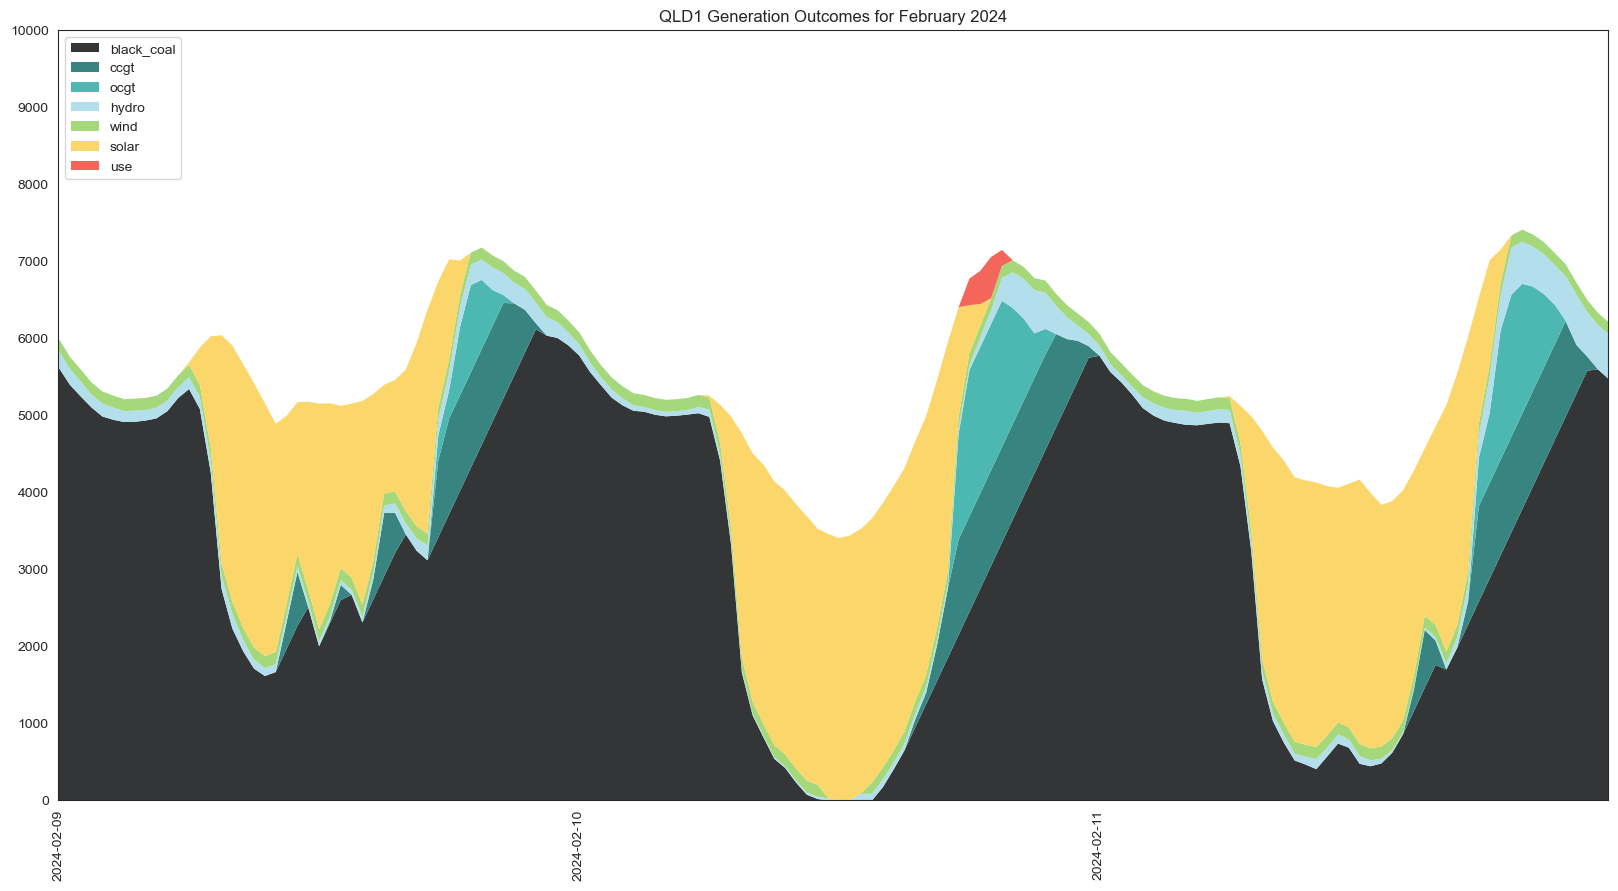

In [9]:
# SHow results using an area plot
sns.set_style('white')

plt.figure(figsize=(20, 10))
plt.stackplot(df['IntervalEnd'], df['black_coal'], df['ccgt'], df['ocgt'], df['wind'], df['hydro'], df['solar'], df['use'], labels=df.columns[4:-1], linewidth=0, colors=technologies)
plt.title('QLD1 Generation Outcomes for February 2024')
plt.xlim(df['IntervalEnd'].min(), df['IntervalEnd'].max())
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.ylim(0, 10000)
plt.yticks(np.arange(0, 10000+1, 1000))
plt.legend(loc='upper left')

plt.show()

In [10]:
# Print total demand, and total generation for each generator
print(f"Total Demand: {df['demand'].sum()/1000:.2f} GWh")

# for all but last generator
for generator in generators:
    print(f"Total {generator} Generation: {df[generator].sum()/1000:.2f} GWh")

Total Demand: 790.39 GWh
Total black_coal Generation: 478.80 GWh
Total ccgt Generation: 42.03 GWh
Total ocgt Generation: 26.22 GWh
Total hydro Generation: 21.84 GWh
Total wind Generation: 24.75 GWh
Total solar Generation: 195.24 GWh
Total use Generation: 1.52 GWh
